In [ ]:
import os
import numpy as np
import pandas as pd
import math
import time
import datetime
from collections import OrderedDict
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn import metrics
from sklearn import tree
from sklearn import ensemble
from sklearn import neural_network
import statsmodels.api as sm
import statsmodels.formula.api as smf
from timeit import default_timer as timer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
import shutil

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

inFile = "Hackathon_CourseMatchPricingData_2013-Present.xlsx"
intermediateFile = "Hackathon_CourseMatch_Preprocessed.csv"
outFile = "Hackathon_CourseMatch_Predicted.xlsx"




class PreProcessor(object):
    def __init__(self):
        pass

    def preProcess(self, inFile, outFile):
        self.inFile = inFile
        self.outFile = outFile
        self.df = pd.read_excel(inFile)

        self.preProcessTerm()
        self.preProcessPrimarySectionId()
        #self.preProcessInstructor()
        self.preProcessPartOfTerm()
        self.preProcessStartDate()
        self.preProcessEndDate()
        self.preProcessStartTime()
        self.preProcessStopTime()
        self.preProcessPrice()
        self.preProcessDaysCode()
        self.preProcessDeptCode()

        # preprocess the instructor at the end because this adds bunch of columns
        self.preProcessInstructor()

        self.encodeCategoricalVariables()

        # Save preprocessed data
        # to_excel takes too long(2min). use to_csv instead
        #self.df.to_excel(outFile, index=False)
        self.df.to_csv(outFile)

    def preProcessTerm(self):
        """
        Converts term format from YYYYA/C to YYYY10/30
        A -> 10, C -> 30
        """
        def convert_term_format(term):
            term = str(term)
            year = term[:4]
            if term[-1] in ['A', 'C']:
                suffix = term[4]
                suffix_map = {'A': '10', 'C': '30'}
                numeric_suffix = suffix_map.get(suffix, '00')
                return f"{year}{numeric_suffix}", year
            return term, year

        self.df[['term_std', 'year']] = (
            self.df['term'].apply(lambda x: pd.Series(convert_term_format(x)))
        )

    def preProcessPrimarySectionId(self):
        """
        Splits primary_section_id into department, course, and section codes
        Also standardizes course_code format
        """
        def get_difficulty(course_code):
          course_code_int = int(course_code)
          if course_code_int < 6000:
            return 'BASIC'
          if course_code_int < 7000:
            return 'INTERMEDIATE'
          if course_code_int < 8000:
            return 'ADVANCED'
          if course_code_int < 10000:
            return 'EXPERT'
          raise Exception("unexpected course_code: {}".format(course_code))

        def split_primary_section_id(section_id):
            section_id = str(section_id)
            dept_code = section_id[:4]
            course_code = section_id[4:7] if len(section_id) == 10 else section_id[4:8]
            if len(course_code) == 3:
              course_code = course_code + '0'
            section_code = section_id[-3:]
            difficulty = get_difficulty(course_code)
            return dept_code, course_code, section_code, dept_code+course_code, difficulty

        # Split into separate columns
        self.df[['dept_code', 'course_code', 'section_code', 'course_id', 'difficulty']] = (
            self.df['primary_section_id'].apply(lambda x: pd.Series(split_primary_section_id(x)))
        )

    def preProcessInstructor(self):
      """
      Processes instructor names and creates instructor-related columns,
      including instructor_std, num_instructors, and T/F values for instructor columns
      """
      def standardize(name):
        return name.strip().replace('.', '').casefold()

      def __get_standardized_instructors(raw_instructors):
        std_instructors = []
        if isinstance(raw_instructors, float): # NAN
            raw_instructors = ""
        instructors = [raw_instructors]
        if '/' in raw_instructors:
          instructors = raw_instructors.split('/')
        elif ',' in raw_instructors:
          # , might have been used either to denote last name or to indicate two or more instructors
          instructors = [standardize(x) for x in raw_instructors.split(',')]
          if len(instructors) > 2:
            raise Exception('error: too many instructors separated by comma')
          elif len(instructors) == 2 and len(instructors[1]) == 1:
            instructors = [instructors[0] + " " + instructors[1]]
        for instructor in instructors:
          std_instructor = standardize(instructor)
          if std_instructor != '':
            std_instructors.append(std_instructor)
        return std_instructors

      def get_full_name_dict(raw_instructor_series):
        name_dict = OrderedDict()
        # make full dictionary of names
        for raw_instructors in raw_instructor_series:
          std_instructors = __get_standardized_instructors(raw_instructors)
          for instructor in std_instructors:
              name_dict[instructor] = instructor
        return name_dict

      def merge_similar(name_dict):
        # iterate name_dict in reverse sorted order
        names = list(reversed(sorted(name_dict.keys())))
        unique_names = []
        i = 0
        while i < len(names) - 1:
          representative = names[i]
          unique_names.append(representative)
          for j in range(i + 1, len(names)):
            name = names[j]
            if name == "":
              break
            #print("comparing {} with {}".format(name, representative))
            # set representative name in all consecutive names that is a shortened version of representative name
            if name + " " in representative:
              name_dict[name] = representative
              #print("replaced")
            else:
              break
          i = j
          unique_names.reverse()
        return unique_names, name_dict

      def get_standardized_instructors(raw_instructors):
        std_instructors = __get_standardized_instructors(raw_instructors)
        std_instructors = [name_dict[i] for i in std_instructors]
        return std_instructors

      def rename(raw_instructors, name_dict):
        std_instructors = get_standardized_instructors(raw_instructors)
        return '/'.join(sorted(std_instructors)), len(std_instructors)

      def make_instructor_matrix(unique_names):
        d = OrderedDict()
        # fill instructor columns
        l = len(self.df)
        for name in unique_names:
          d[name] = [0] * l

        for i, raw_instructors in enumerate(self.df["instructor"]):
          std_instructors = get_standardized_instructors(raw_instructors)
          for instructor in std_instructors:
            d[instructor][i] = 1

        inst_df = pd.DataFrame(d, columns=sorted(d.keys()))
        return inst_df

      name_dict = get_full_name_dict(self.df["instructor"])
      unique_names, name_dict = merge_similar(name_dict)
      #print(name_dict)
      print("unique instructors: {}".format(len(unique_names)))

      # fill standardized instructor names and number of instructors
      self.df[["instructor_std", "num_instructors"]] = self.df["instructor"].apply(lambda x: pd.Series(rename(x, name_dict)))

      #inst_df = make_instructor_matrix(unique_names)
      #self.df = pd.concat([self.df, inst_df], axis=1)

    def preProcessInstructor_Orig(self):
        """
        Processes instructor names and creates instructor-related columns
        """
        def name_parser(names):
            all_names = set()
            idx2name_better = dict()
            idx2n_instructor = dict()
            for i, name in enumerate(names):
                idx2name_better[i] = set()
                idx2n_instructor[i] = np.nan
                if isinstance(name, float):  # NAN
                    continue
                name = name.strip()
                individuals = name.split("/")
                c = 0
                for ind in individuals:
                    thyname = ind.strip().replace(",", "").casefold().split(" ")
                    thyname = tuple(x for x in thyname if len(x) > 0)
                    if len(thyname) > 0:
                        all_names.add(thyname)
                        idx2name_better[i].add(thyname)
                        c += 1
                idx2n_instructor[i] = c
            return all_names, idx2name_better, idx2n_instructor

        def _is_in_name_lookup_similar(name_lookup, name):
            if name in name_lookup:
                return True, name
            for x in name_lookup:
                if name[0] == x[0]:
                    if len(name) == 1 or len(x) == 1:
                        return True, x
                    if len(name) == 2 and len(x) == 2:
                        if name[1][0] == x[1][0]:
                            return True, x
            return False, None

        def name_refiner(all_names):
            name_lookup = dict()
            uid = 0
            for name in all_names:
                boo, name_ = _is_in_name_lookup_similar(name_lookup, name)
                if boo:
                    name_lookup[name] = name_lookup[name_]
                else:
                    name_lookup[name] = uid
                    uid += 1
            return name_lookup

        # Process names
        all_names, idx2name_better, idx2n_instructor = name_parser(self.df["instructor"])
        name_lookup = name_refiner(all_names)
        uids = {u for u in name_lookup.values()}

        # Create instructor columns
        for i in range(len(uids)):
            self.df[f"name_{i}"] = False

        # Fill instructor data
        for index, row in self.df.iterrows():
            for n in idx2name_better[index]:
                if n in name_lookup:
                    i = name_lookup[n]
                    self.df.loc[index, f"name_{i}"] = True

        self.df["num_instructors"] = pd.Series(idx2n_instructor)

    def preProcessPartOfTerm(self):
        """
        Creates start_quarter column based on part_of_term
        """
        def get_length(part_of_term):
          part_of_term = str(part_of_term).strip()
          if part_of_term in ['F', 'S']:
            return 'FULL'
          elif part_of_term in ['1', '2', '3', '4']:
            return 'HALF'
          elif part_of_term in ['M', 'Modular']:
            return 'MODULAR'
          else:
            raise Exception('error: unexpected part_of_term: {}'.format(part_of_term))

        def set_quarters(part_of_term):
          q, m = [0] * 5, 0
          if isinstance(part_of_term, int):
            q[part_of_term] = 1
          elif part_of_term == 'F':
            q[1], q[2] = 1, 1
          elif part_of_term == 'S':
            q[3], q[4] = 1, 1
          elif part_of_term in ['M', 'Modular']:
            m = 1
          else:
            raise Exception('error: unexpected part_of_term: {}'.format(part_of_term))
          return (q[1], q[2], q[3], q[4], m)

        self.df['length'] = self.df['part_of_term'].apply(get_length)
        self.df[['isQ1', 'isQ2', 'isQ3', 'isQ4', 'isMod']] = self.df['part_of_term'].apply(
            lambda x: pd.Series(set_quarters(x))
        )

    def preProcessStartDate(self):
        """
        Processes start_date and extracts start_month
        """
        self.df['start_month'] = self.df['start_date'].dt.month

    def preProcessEndDate(self):
        """
        Processes end_date and calculates term duration
        """
        self.df['num_days'] = (pd.to_datetime(self.df['end_date']) - pd.to_datetime(self.df['start_date'])).dt.days

    def preProcessStartTime(self):
        """
        Processes start_time and contributes to class_duration calculation
        """
        def get_time(t):
            if isinstance(t, datetime.time):
                result = t
            elif isinstance(t, int):
                t = str(t)
                if len(t) not in [3, 4]:
                    return None
                hh, mm = int(t[:-2]), int(t[-2:])
                result = datetime.time(hh, mm)
            else:
                return None
            return datetime.datetime.combine(datetime.date.today(), result)

        def get_time_classification(t):
          today = datetime.datetime.combine(datetime.date.today(), datetime.time(hour=0,minute=0,second=0,microsecond=0))
          if t < today.replace(hour=9, minute=30): # before 9:30
            return 'EARLY_MORNING'
          if t < today.replace(hour=11, minute=0): # before 11:00
            return 'MORNING'
          if t < today.replace(hour=12, minute=30): # before 12:30
            return 'NOON'
          if t < today.replace(hour=14, minute=00): # before 14:00
            return 'EARLY_AFTERNOON'
          if t < today.replace(hour=16, minute=00): # before 16:00
            return 'AFTERNOON'
          if t < today.replace(hour=18, minute=00): # before 18:00
            return 'EARLY_EVENING'
          if t < today.replace(hour=20, minute=00): # before 20:00
            return 'EVENING'
          if t < today.replace(hour=23, minute=59): # before 23:59
            return 'NIGHT'
          else:
            return np.nan

        self.df['class_duration'] = pd.Series(dtype="float")
        zero_time = datetime.datetime.combine(datetime.date.today(), datetime.time(0, 0))
        zero_time = time.mktime(zero_time.timetuple())

        for index, row in self.df.iterrows():
            t_stop = get_time(row["stop_time_24hr"])
            t_start = get_time(row["start_time_24hr"])

            if (t_start is None or t_stop is None or
                np.isclose(time.mktime(t_stop.timetuple()), zero_time) or
                np.isclose(time.mktime(t_start.timetuple()), zero_time)):
                self.df.loc[index, "class_duration"] = np.nan
                self.df.loc[index, "start_time_cls"] = np.nan
            else:
                self.df.loc[index, "class_duration"] = (t_stop - t_start).total_seconds() / 3600
                self.df.loc[index, "start_time_cls"] = get_time_classification(t_start)

    def preProcessStopTime(self):
        """
        Stop time processing is handled in preProcessStartTime as part of duration calculation
        """
        pass

    def preProcessPrice(self):
        """
        Creates full column based on price
        """
        def is_zero(price):
          if math.isnan(price):
            return np.nan
          return 1 if price == 0 else 0

        self.df['price_is_zero'] = self.df['price'].apply(is_zero)

    def preProcessDaysCode(self):
        self.df["days_code"] = self.df["days_code"].apply(lambda x: x.strip())

    def preProcessDeptCode(self):
        self.df["dept_code"] = self.df["dept_code"].apply(lambda x: x.strip())

    def encodeCategoricalVariables(self):
      """
      data_to_encode = self.df[['days_code', 'dept_code', 'difficulty', 'start_time_cls', 'length']]
      encoded_df = pd.get_dummies(data=data_to_encode, drop_first=False)
      self.df = pd.concat([self.df, encoded_df], axis=1)


      # Initialize LabelEncoder
      label_encoder = LabelEncoder()

      # Fit and transform the categorical variables
      self.df['course_id_enc'] = label_encoder.fit_transform(self.df['course_id'])
      self.df['instructor_std_enc'] = label_encoder.fit_transform(self.df['instructor_std'])
      """

      # One-hot transform course_id_enc and instructor_std_enc
      def _combiner(feature, category):
          return str(feature) + "_" + str(category)

      enc = OneHotEncoder(feature_name_combiner=_combiner, handle_unknown="ignore")
      data = enc.fit_transform(self.df[["days_code", "dept_code", "difficulty", "start_time_cls", "length", "course_id", "instructor_std"]])
      cols = enc.get_feature_names_out()
      df1 = pd.DataFrame(data.toarray(), columns=cols, dtype=int)
      self.df = pd.concat([self.df, df1], axis=1)

class PredictorModel(object):
  def __init__(self, name, formula=None):
    self.name = name
    self.formula = None
    self.x_labels = None
    self.y_label = None

    self.set_formula(formula)

    self.init()

  def init(self):
    pass

  def train(self, data):
    pass

  def set_train_rmse(self, rmse):
    self.train_rmse = rmse

  def set_validation_rmse(self, rmse):
    self.validation_rmse = rmse

  def set_train_mae(self, mae):
    self.train_mae = mae

  def set_validation_mae(self, mae):
    self.validation_mae = mae

  def set_train_r2(self, r2):
    self.train_r2 = r2

  def set_validation_r2(self, r2):
    self.validation_r2 = r2

  def validate(self, data, ans):
    y_hat = self.predict(data)
    self.rmse = np.sqrt(metrics.mean_squared_error(ans, y_hat))
    self.mae = metrics.mean_absolute_error(ans, y_hat)
    self.r2 = metrics.r2_score(ans, y_hat)

  def predict(self, data):
    return self.clf.predict(data[self.x_labels])

  def set_formula(self, formula):
    self.formula = formula
    if formula is not None:
      x, y = self.get_feature_from_formula(formula)
      self.set_labels(x, y)

  def set_labels(self, x_labels, y_label):
    self.x_labels = x_labels
    self.y_label = y_label

  def get_feature_from_formula(self, formula):
      x_labels = [x.strip() for x in formula.split("~")[1].split("+")]
      x_labels = [x[2:-1] if x[:2]=="C(" and x[-1]==")" else x for x in x_labels]
      y_label = formula.split("~")[0].strip()
      return x_labels, y_label

class OLSFModel(PredictorModel):
  def train(self, data):
    self.clf = smf.ols(self.formula, data).fit()

class OLSModel(PredictorModel):
  def train(self, data):
    self.clf = sm.OLS(data[self.y_label], data[self.x_labels]).fit()

class DTModel(PredictorModel):
  def train(self, data):
    clf = tree.DecisionTreeRegressor()
    self.clf = clf.fit(data[self.x_labels], data[self.y_label])

class RFModel(PredictorModel):
  def train(self, data):
    clf = ensemble.RandomForestRegressor()
    self.clf = clf.fit(data[self.x_labels], data[self.y_label])

class NNModel(PredictorModel):
  def init(self):
    self.ss = StandardScaler()
  def train(self, data):
    kwargs = dict(
        verbose=False,
        hidden_layer_sizes=(50,5,50),
        activation="relu",
        solver="sgd",
        alpha=0.0001,
        batch_size="auto",
        learning_rate_init=0.001,
        max_iter=2000,
        tol=0.0001,
        momentum=0.9,
        nesterovs_momentum=True,
        validation_fraction=0.1,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08,
    )
    # tmp = pd.DataFrame(np.column_stack((data['price'].values,StandardScaler().fit_transform(data.iloc[:,data.columns!='price']))),columns = data.columns).set_index(data.index)
    # tmp = pd.DataFrame(StandardScaler().fit_transform(data), columns=data.columns)
    """
    StandardScaler().fit_transform():
    standardize numerical predictor columns for train
    standardize price columns for train

    StandardScaler().inverse_transform()
    """
    tmp = pd.DataFrame(self.ss.fit_transform(data), columns=data.columns)
    clf = neural_network.MLPRegressor(**kwargs)
    self.clf = clf.fit(tmp[self.x_labels], tmp[self.y_label])

  def invTransform(self, scaler, data, colName, colNames):
    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy[colName].values

  def validate(self, data, ans):
    tmp = pd.DataFrame(self.ss.transform(data), columns=data.columns)
    y_hat = self.predict(tmp)
    y_hat = self.invTransform(self.ss, y_hat, "price", data.columns)
    self.rmse = np.sqrt(metrics.mean_squared_error(ans, y_hat))
    self.mae = metrics.mean_absolute_error(ans, y_hat)
    self.r2 = metrics.r2_score(ans, y_hat)

class DTTunedModel(PredictorModel):
  def train(self, data):
    # Define the hyperparameter grid
    param_grid = {
        'max_depth': [None, 5, 10, 15, 20],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 5, 10],
        'max_features': [None, 'sqrt', 'log2'],
        'ccp_alpha': [0.0, 0.01, 0.05, 0.1],
    }

    # Initialize the model
    clf = DecisionTreeRegressor(random_state=42)

    # Use RandomizedSearchCV for hyperparameter tuning
    search = RandomizedSearchCV(
        estimator=clf,
        param_distributions=param_grid,
        n_iter=50,  # Number of random combinations to try
        scoring='neg_mean_squared_error',
        cv=5,  # 5-fold cross-validation
        verbose=1,
        random_state=42,
        n_jobs=-1  # Use all processors
    )

    # Fit the RandomizedSearchCV on training data
    search.fit(data[self.x_labels], data[self.y_label])

    # Save the best estimator
    self.clf = search.best_estimator_

    # Print the best hyperparameters
    print("Best Hyperparameters:", search.best_params_)


class GBDTModel(PredictorModel):
  def train(self, data):
    kwargs = dict(loss='squared_error', quantile=None, learning_rate=0.1, max_iter=100, max_leaf_nodes=31, max_depth=None, min_samples_leaf=20, l2_regularization=0.0, max_features=1.0, max_bins=255, categorical_features=None, monotonic_cst=None, interaction_cst=None, warm_start=False, early_stopping='auto', scoring='loss', validation_fraction=0.1, n_iter_no_change=10, tol=1e-07, verbose=0, random_state=None)
    clf = ensemble.HistGradientBoostingRegressor(**kwargs)
    self.clf = clf.fit(data[self.x_labels], data[self.y_label])

class GBDTTunedModel(PredictorModel):
  def train(self, data):
    param_grid = {
        'learning_rate': [0.01],
        'max_iter': [100, 200],
        'max_leaf_nodes': [15],
        'min_samples_leaf': [10],
        'max_depth': [5],
        'l2_regularization': [0.5],
    }
    clf = ensemble.HistGradientBoostingRegressor()
    search = RandomizedSearchCV(
        estimator=clf,
        param_distributions=param_grid,
        n_iter=50,
        scoring='neg_mean_squared_error',
        cv=5,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    search.fit(data[self.x_labels], data[self.y_label])
    self.clf = search.best_estimator_
    print("Best Hyperparameters:", search.best_params_)

class Predictor(object):
  def __init__(self):
    pass

  def predict(self, inFile, outFile):
    self.inFile = inFile
    self.outFile = outFile
    self.df = pd.read_csv(inFile)

    self.preprocess()

    self.prepare_models()
    self.do_train()
    self.print_model_performance()
    # self.do_predict()

    self.test_data.to_excel(outFile, index=False)

  def preprocess(self):
    self.split_data()
    self.remove_incomplete_data()
    self.drop_unused_columns()
    self.cast_bool_to_int()
    self.check_data_types()
    self.print_data_shapes()

  def split_data(self):
    # Define the condition for the test set (term 202510) and training set (all others)
    data = self.df
    self.test_data = data[data['term_std'] == 202510]
    self.validation_data = data[data['term_std'] == 202430]
    self.train_data = data[~data['term_std'].isin([202510, 202430])]

  def remove_incomplete_data(self):
    # Finding null values in the training data
    null_counts_train = self.train_data.isnull().sum()
    null_counts_train = null_counts_train[null_counts_train > 0]  # Filter to show only columns with null values
    #print(null_counts_train)
    self.train_data = self.train_data.dropna()

    # Checking to ensure all null values have been removed
    null_counts_train_cleaned = self.train_data.isnull().sum().sum()  # Sum of all null values in the cleaned training set
    #print(self.train_data.shape, null_counts_train_cleaned)

  def drop_unused_columns(self):
    columns_to_drop = ['Unnamed: 0', 'term', 'primary_section_id', 'title', 'part_of_term', 'start_date', 'end_date', 'start_time_24hr','stop_time_24hr', 'instructor',
                       'days_code', 'dept_code', 'course_id', 'difficulty', 'length', 'start_time_cls', 'instructor_std']

    # Dropping the specified columns from the DataFrame
    self.train_data = self.train_data.drop(columns=columns_to_drop)
    self.validation_data = self.validation_data.drop(columns=columns_to_drop)
    self.test_data = self.test_data.drop(columns=columns_to_drop)

  def cast_bool_to_int(self):
    # Converting all boolean columns to numerical (0 for False, 1 for True)
    bool_columns = self.train_data.select_dtypes(include=['bool']).columns
    self.train_data[bool_columns] = self.train_data[bool_columns].astype(int)
    self.validation_data[bool_columns] = self.validation_data[bool_columns].astype(int)
    self.test_data[bool_columns] = self.test_data[bool_columns].astype(int)

  def check_data_types(self):
    # Checking data types in the training data
    object_columns = self.train_data.select_dtypes(include=['object']).columns
    numerical_columns = self.train_data.select_dtypes(include=['int64', 'float64']).columns

    # Counting the number of object (categorical) and numerical columns
    num_object_columns = len(object_columns)
    num_numerical_columns = len(numerical_columns)

    print("num_object_columns = {}, num_numerical_columns = {}".format(num_object_columns, num_numerical_columns))
    #print(self.train_data[object_columns].dtypes)

  def print_data_shapes(self):
    print("Training data shape:", self.train_data.shape)
    print("Validation data shape:", self.validation_data.shape)
    print("Test data shape:", self.test_data.shape)
    #print(self.train_data.iloc[0])

  def prepare_models(self):
    self.models = OrderedDict()
    formula_base = self.make_base_formula()

    self.models["ols_base"] = OLSFModel("ols_base", formula_base)
    self.models["dt_base"] = DTModel("dt_base", formula_base)
    self.models["rf_base"] = RFModel("rf_base", formula_base)
    self.models["nn_base"] = NNModel("nn_base", formula_base)
    self.models["gbdt_base"] = GBDTModel("gbdt_base", formula_base)

    formula_inst_course = self.make_inst_course_formula()

    self.models["ols_inst_course"] = OLSModel("ols_inst_course", formula_inst_course)
    self.models["dt_inst_course"] = DTModel("dt_inst_course", formula_inst_course)
    self.models["rf_inst_course"] = DTModel("rf_inst_course", formula_inst_course)
    self.models["nn_inst_course"] = NNModel("nn_inst_course", formula_inst_course)
    self.models["gbdt_inst_course"] = GBDTModel("gbdt_inst_course", formula_inst_course)

    #self.models["dt_tuned"] = DTTunedModel("dt_tuned", formula_inst_course)
    #self.models["gbdt_inst_course_tuned"] = GBDTTunedModel("gbdt_inst_course_tuned", formula_inst_course)

    #formula_coltest = self.make_coltest_formula()
    #self.models["ols_coltest"] = OLSModel("ols_coltest", formula_coltest)
    #self.models["dt_coltest"] = DTModel("dt_coltest", formula_coltest)

  def add_categorical_variable(self, formula, variable):
    cols = [x for x in self.train_data.columns if x.startswith(variable + "_")]
    formula += " + " + "+".join(cols[:-1]) # remove last one to avoid collinearity
    return formula

  def make_base_formula(self):
    formula = "price ~ "
    formula += "  capacity"
    formula += "  + credit_unit"
    formula += "  + term_std"
    formula = self.add_categorical_variable(formula, "start_time_cls")
    return formula

  def make_inst_course_formula(self):
    formula = self.make_base_formula()
    formula = self.add_categorical_variable(formula, "course_id")
    formula = self.add_categorical_variable(formula, "instructor_std")
    return formula

  def make_coltest_formula(self):
    formula = "price ~ "
    formula += "  capacity"
    formula += "  + credit_unit"
    formula += "  + term_std"
    #formula += "  + year"
    #formula += "  + isQ1"
    #formula += "  + isQ2"
    #formula += "  + isQ3"
    #formula += "  + isQ4"
    #formula += "  + start_month" # using term_std is better than year+Quarter or year+start_month

    formula = self.add_categorical_variable(formula, "start_time_cls")
    formula = self.add_categorical_variable(formula, "course_id")
    formula = self.add_categorical_variable(formula, "instructor_std")
    #formula = self.add_categorical_variable(formula, "difficulty")
    #formula = self.add_categorical_variable(formula, "days_code")
    #formula = self.add_categorical_variable(formula, "dept_code")
    #formula = self.add_categorical_variable(formula, "length")

    return formula

  def do_train(self):
    # print("{: >16}{: >16}{: >16}{: >16}".format("model", "train_rmse", "valid_rmse", "elapsed(s)"))
    for name, model in self.models.items():
      start = timer()
      model.train(self.train_data)
      model.validate(self.train_data, self.train_data["price"])
      model.set_train_rmse(model.rmse)
      model.set_train_mae(model.mae)
      model.set_train_r2(model.r2)
      model.validate(self.validation_data, self.validation_data["price"])
      model.set_validation_rmse(model.rmse)
      model.set_validation_mae(model.mae)
      model.set_validation_r2(model.r2)
      end = timer()
      elapsed = end - start
      # print("{: >16}{:16.2f}{:16.2f}{:16.2f}".format(model.name, model.train_rmse, model.validation_rmse, elapsed))

  def print_model_performance(self):
    print("{: >16}{: >16}{: >16}".format("model", "train_rmse", "valid_rmse"))
    for name, model in self.models.items():
      print("{: >16}{:16.2f}{:16.2f}".format(model.name, model.train_rmse, model.validation_rmse))

    print("{: >16}{: >16}{: >16}".format("model", "train_mae", "valid_mae"))
    for name, model in self.models.items():
      print("{: >16}{:16.2f}{:16.2f}".format(model.name, model.train_mae, model.validation_mae))

    print("{: >16}{: >16}{: >16}".format("model", "train_r2", "valid_r2"))
    for name, model in self.models.items():
      print("{: >16}{:16.2f}{:16.2f}".format(model.name, model.train_r2, model.validation_r2))

  def get_validation_rmse_dict(self):
    rmse_list = dict()
    for name, model in self.models.items():
      rmse_list[model.name] = model.validation_rmse
    return rmse_list

  def get_validation_mae_dict(self):
    rmse_list = dict()
    for name, model in self.models.items():
      rmse_list[model.name] = model.validation_mae
    return rmse_list

  def get_validation_r2_dict(self):
    rmse_list = dict()
    for name, model in self.models.items():
      rmse_list[model.name] = model.validation_r2
    return rmse_list

  def get_train_rmse_dict(self):
    rmse_list = dict()
    for name, model in self.models.items():
      rmse_list[model.name] = model.train_rmse
    return rmse_list

  def get_train_mae_dict(self):
    rmse_list = dict()
    for name, model in self.models.items():
      rmse_list[model.name] = model.train_mae
    return rmse_list

  def get_train_r2_dict(self):
    rmse_list = dict()
    for name, model in self.models.items():
      rmse_list[model.name] = model.train_r2
    return rmse_list

  def do_predict(self):
    min_rmse_model = min(self.models.values(), key=lambda model: model.rmse)
    return min_rmse_model.predict(self.test_data)

# def main():
#   preProcessor = PreProcessor()
#   preProcessor.preProcess(inFile, intermediateFile)
#   predictor = Predictor()
#   predictor.predict(intermediateFile, outFile)

# if __name__ == "__main__":
#   main()

In [ ]:
predictor.df['instructor_std'].nunique()

654

In [ ]:
a_old = set(predictor.train_data["course_id"].unique())
a_new = set(predictor.validation_data["course_id"].unique())
len(a_old.difference(a_new))

177

In [ ]:
# preProcessor = PreProcessor()
# preProcessor.preProcess(inFile, intermediateFile)
predictor = Predictor()
predictor.predict(intermediateFile, outFile)

<ipython-input-123-31397e670fff>:628: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(inFile)


num_object_columns = 0, num_numerical_columns = 1047
Training data shape: (6682, 1047)
Validation data shape: (179, 1047)
Test data shape: (235, 1047)
           model      train_rmse      valid_rmse
        ols_base          751.59          896.65
         dt_base          462.21          932.21
         rf_base          490.03          841.07
         nn_base          707.66          857.93
       gbdt_base          622.65          773.50
 ols_inst_course          483.67          904.81
  dt_inst_course          228.95          585.05
  rf_inst_course          228.95          596.94
  nn_inst_course          453.85          631.49
gbdt_inst_course          533.82          741.20
           model       train_mae       valid_mae
        ols_base          549.34          679.64
         dt_base          250.65          627.70
         rf_base          310.23          601.38
         nn_base          505.74          637.01
       gbdt_base          431.50          557.37
 ols_inst_course

In [ ]:
def invTransform(self, scaler, data, colName, colNames):
  dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
  dummy[colName] = data
  dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
  return dummy[colName].values




In [ ]:
min_rmse_model = predictor.models["nn_inst_course"]

tmp = pd.DataFrame(min_rmse_model.ss.transform(predictor.test_data), columns=predictor.test_data.columns)
y_hat = min_rmse_model.predict(tmp)
a = min_rmse_model.invTransform(min_rmse_model.ss, y_hat, "price", predictor.test_data.columns)

# a = min_rmse_model.predict(predictor.test_data)

In [ ]:
min_rmse_model = predictor.models["gbdt_inst_course"]

a = min_rmse_model.predict(predictor.test_data)

In [ ]:
for x in a:
  print(x)

1159.944294695517
1483.4558179442724
1509.3598081416155
158.08764217429984
-68.7310722475769
9.76855120956439
89.00042234040806
767.6595376831978
187.71598244253278
566.2700223692306
1340.086552907534
1663.5980761562894
1340.086552907534
686.1792514226715
645.6884320069221
-94.73250874114873
887.5375655849163
-40.61238878679071
1297.8665731470921
1625.5498393476853
1655.1528698293462
1670.8892405299543
1366.6802421409557
1377.8986999501367
172.17244858919352
380.92443505243756
431.8777026367431
351.0605860136955
483.02581729308315
722.5364205408932
837.9884437413147
735.8159128553718
1663.5980761562894
1672.0723025902093
276.49980125331234
1663.5980761562894
147.6158407116623
157.94729685486547
127.2952966598499
350.9521038474357
142.6515377860045
1672.0723025902093
835.5541177880942
1433.584841475205
1628.1233237090096
1045.686839236698
297.2044598931545
1796.368165894998
443.61982724613904
668.8035804053354
369.5311162326451
451.29417935156425
271.56984080232354
121.55896748619739
68

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
rmse = predictor.get_validation_rmse_dict()
mae = predictor.get_validation_mae_dict()
r2 = predictor.get_validation_r2_dict()
model_names = [name for name in rmse.keys()]
model_names = [x for x in model_names if x.endswith("inst_course")]
name2better = {"ols": "Linear Regression", "dt": "Decision Tree", "gbdt": "Gradient Boosted Decision Tree", "nn": "3-Layer Perceptron", "rf": "Random Forest"}
m1 = np.array([[rmse[m] for m in model_names]]).T
m2 = np.array([[mae[m] for m in model_names]]).T
m3 = np.array([[r2[m] for m in model_names]]).T

X = model_names

M1 = MinMaxScaler((0.1,1)).fit_transform(m1)[:, 0]
M2 = MinMaxScaler((0.1,1)).fit_transform(m2)[:, 0]
M3 = MinMaxScaler((0.1,1)).fit_transform(m3)[:, 0]

X_axis = np.arange(len(X))


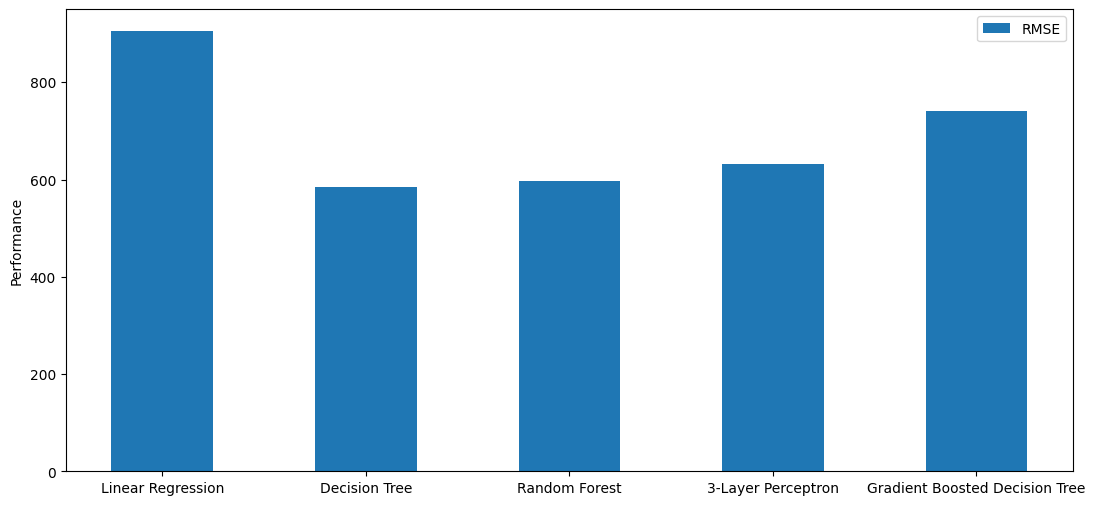

In [ ]:
plt.figure(figsize=(13,6))
plt.bar(X_axis, m1[:, 0], 0.5, label = 'RMSE')
plt.xticks(X_axis, [name2better[x.split("_")[0]] for x in X])
plt.ylabel("Performance")
plt.legend()
plt.show()

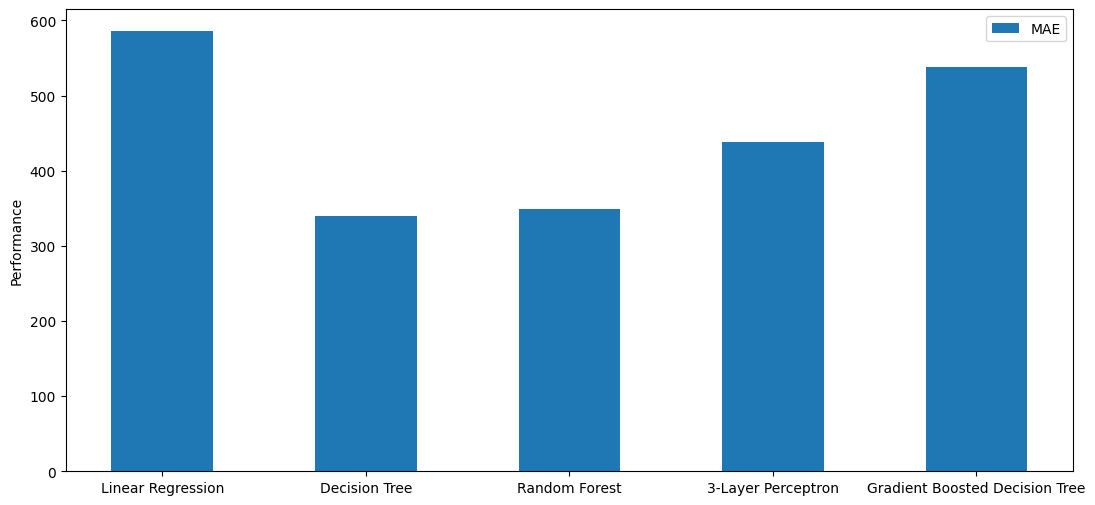

In [ ]:
plt.figure(figsize=(13,6))
plt.bar(X_axis, m2[:, 0], 0.5, label = 'MAE')
plt.xticks(X_axis, [name2better[x.split("_")[0]] for x in X])
plt.ylabel("Performance")
plt.legend()
plt.show()

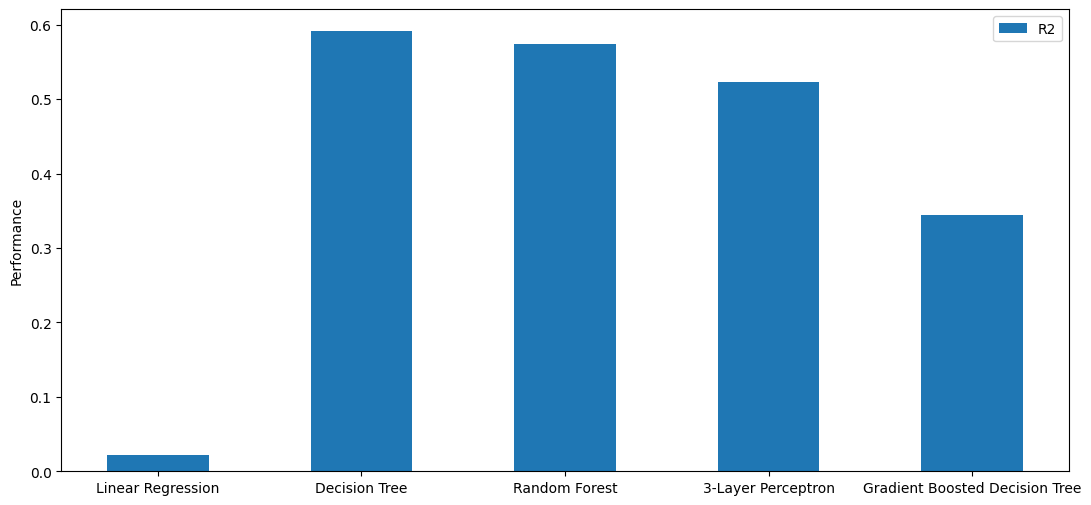

In [ ]:
plt.figure(figsize=(13,6))
plt.bar(X_axis, m3[:, 0], 0.5, label = 'R2')
plt.xticks(X_axis, [name2better[x.split("_")[0]] for x in X])
plt.ylabel("Performance")
plt.legend()
plt.show()

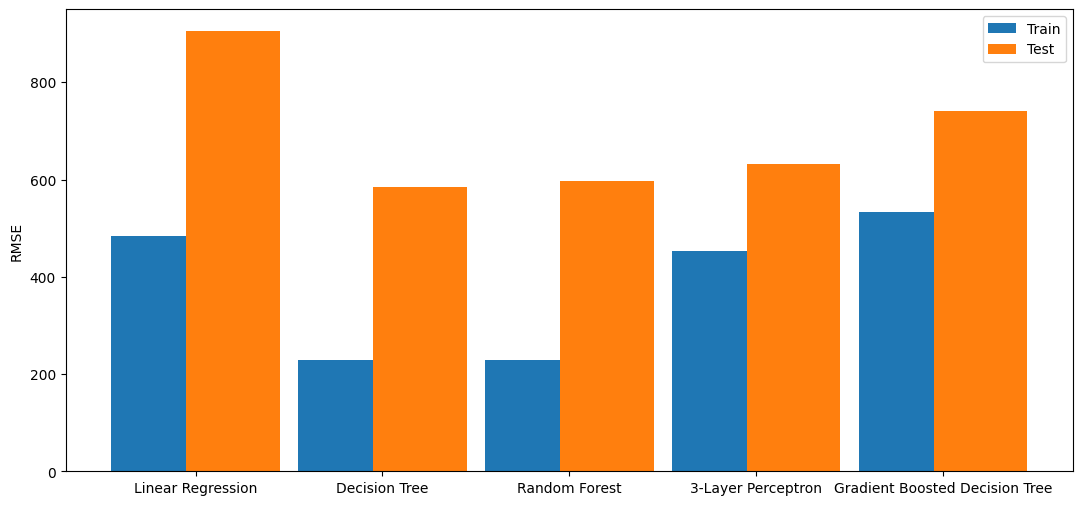

In [ ]:
rmse = predictor.get_validation_rmse_dict()
rmse_t = predictor.get_train_rmse_dict()
model_names = [name for name in rmse.keys()]
model_names = [x for x in model_names if x.endswith("inst_course")]
name2better = {"ols": "Linear Regression", "dt": "Decision Tree", "gbdt": "Gradient Boosted Decision Tree", "nn": "3-Layer Perceptron", "rf": "Random Forest"}

m1_t = np.array([[rmse_t[m] for m in model_names]]).T
m1_v = np.array([[rmse[m] for m in model_names]]).T

X = model_names
X_axis = np.arange(len(X))


plt.figure(figsize=(13,6))
plt.bar(X_axis-0.2, m1_t[:, 0], 0.5, label = 'Train')
plt.bar(X_axis+0.2, m1_v[:, 0], 0.5, label = 'Test')
plt.xticks(X_axis, [name2better[x.split("_")[0]] for x in X])
plt.ylabel("RMSE")
plt.legend()
plt.show()


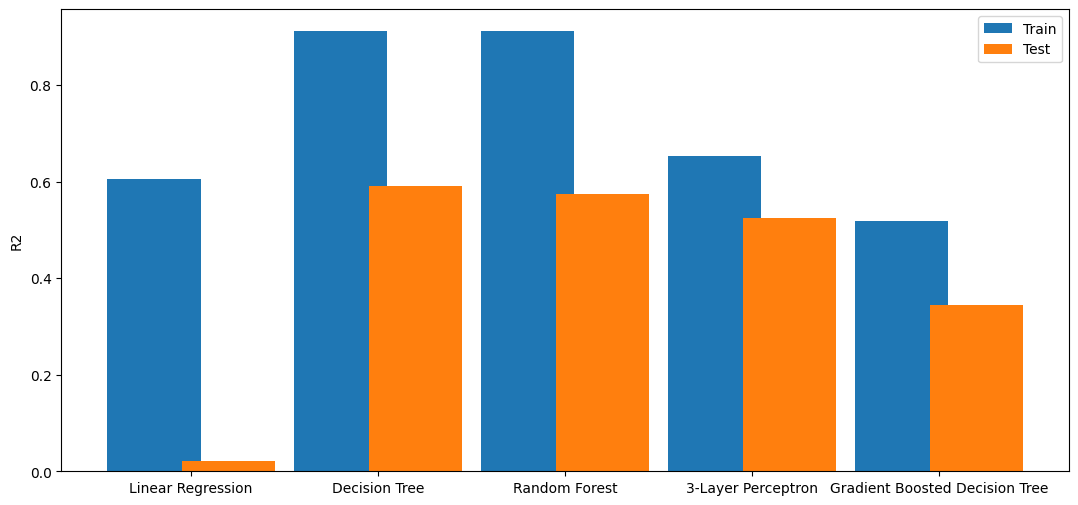

In [ ]:
rmse = predictor.get_validation_r2_dict()
rmse_t = predictor.get_train_r2_dict()
model_names = [name for name in rmse.keys()]
model_names = [x for x in model_names if x.endswith("inst_course")]
name2better = {"ols": "Linear Regression", "dt": "Decision Tree", "gbdt": "Gradient Boosted Decision Tree", "nn": "3-Layer Perceptron", "rf": "Random Forest"}

m1_t = np.array([[rmse_t[m] for m in model_names]]).T
m1_v = np.array([[rmse[m] for m in model_names]]).T

X = model_names
X_axis = np.arange(len(X))


plt.figure(figsize=(13,6))
plt.bar(X_axis-0.2, m1_t[:, 0], 0.5, label = 'Train')
plt.bar(X_axis+0.2, m1_v[:, 0], 0.5, label = 'Test')
plt.xticks(X_axis, [name2better[x.split("_")[0]] for x in X])
plt.ylabel("R2")
plt.legend()
plt.show()


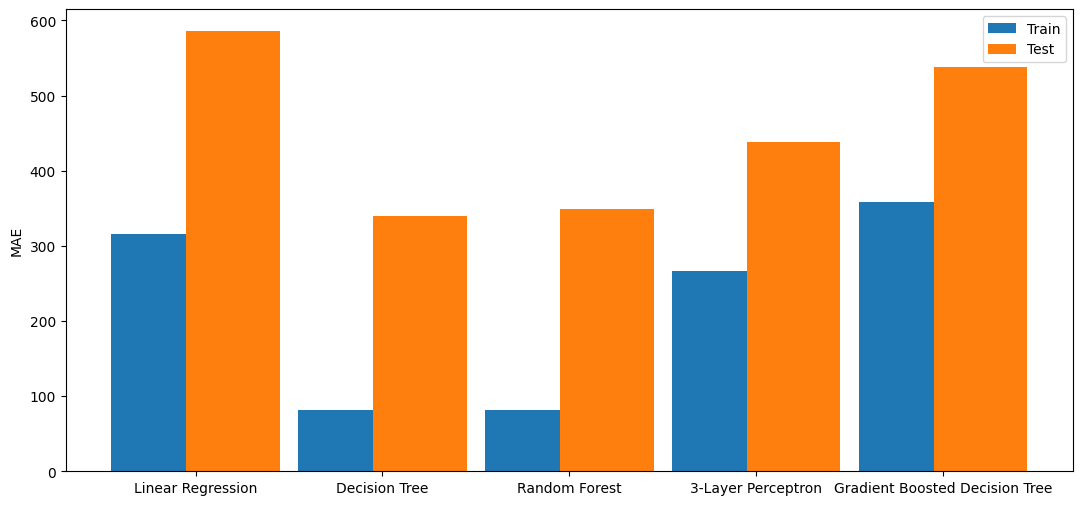

In [ ]:
rmse = predictor.get_validation_mae_dict()
rmse_t = predictor.get_train_mae_dict()
model_names = [name for name in rmse.keys()]
model_names = [x for x in model_names if x.endswith("inst_course")]
name2better = {"ols": "Linear Regression", "dt": "Decision Tree", "gbdt": "Gradient Boosted Decision Tree", "nn": "3-Layer Perceptron", "rf": "Random Forest"}

m1_t = np.array([[rmse_t[m] for m in model_names]]).T
m1_v = np.array([[rmse[m] for m in model_names]]).T

X = model_names
X_axis = np.arange(len(X))


plt.figure(figsize=(13,6))
plt.bar(X_axis-0.2, m1_t[:, 0], 0.5, label = 'Train')
plt.bar(X_axis+0.2, m1_v[:, 0], 0.5, label = 'Test')
plt.xticks(X_axis, [name2better[x.split("_")[0]] for x in X])
plt.ylabel("MAE")
plt.legend()
plt.show()


In [ ]:
rmse = predictor.get_validation_rmse_dict()
mae = predictor.get_validation_mae_dict()
r2 = predictor.get_validation_r2_dict()

rmse_t = predictor.get_train_rmse_dict()
mae_t = predictor.get_train_mae_dict()
r2_t = predictor.get_train_r2_dict()
model_names = [name for name in rmse.keys()]
model_names = [x for x in model_names if x.endswith("inst_course")]
name2better = {"ols": "Linear Regression", "dt": "Decision Tree", "gbdt": "Gradient Boosted Decision Tree", "nn": "3-Layer Perceptron", "rf": "Random Forest"}
m1 = np.array([[rmse[m] - rmse_t[m] for m in model_names]]).T
m2 = np.array([[mae[m] - mae_t[m] for m in model_names]]).T
m3 = np.array([[r2_t[m] - r2[m] for m in model_names]]).T

X = model_names

M1 = MinMaxScaler((0.1,1)).fit_transform(m1)[:, 0]
M2 = MinMaxScaler((0.1,1)).fit_transform(m2)[:, 0]
M3 = MinMaxScaler((0.1,1)).fit_transform(m3)[:, 0]

X_axis = np.arange(len(X))


In [ ]:
print(model_names)
print(m1[:, 0])
print(m2[:, 0])
print(m3[:, 0])

['ols_inst_course', 'dt_inst_course', 'rf_inst_course', 'nn_inst_course', 'gbdt_inst_course']
[421.14139006 356.10222104 367.99503816 177.64393102 207.37958935]
[269.74824142 258.50785137 267.87019774 172.41366015 179.73886794]
[0.58302283 0.32036334 0.3371536  0.12867156 0.17523578]


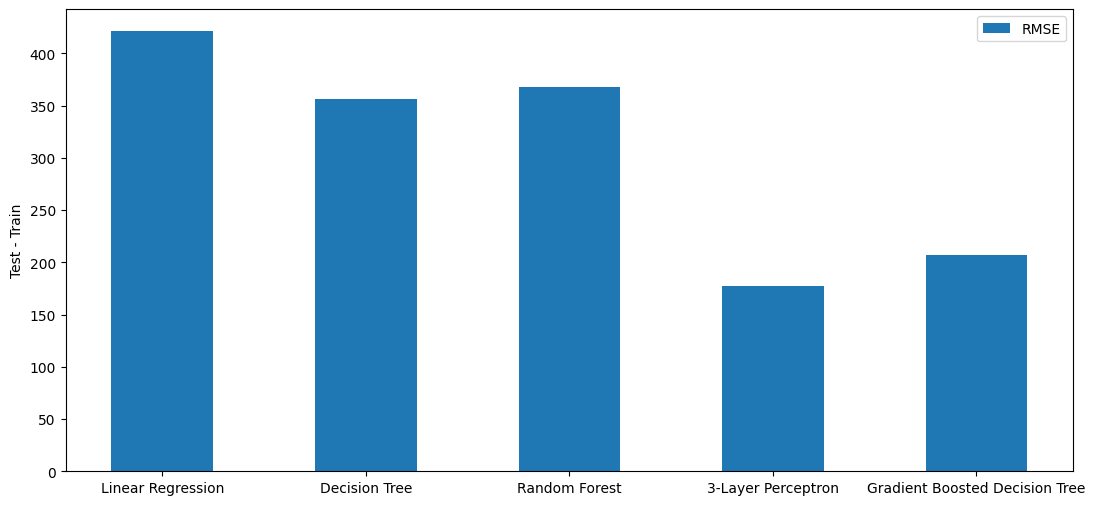

In [ ]:
plt.figure(figsize=(13,6))
plt.bar(X_axis, m1[:, 0], 0.5, label = 'RMSE')
plt.xticks(X_axis, [name2better[x.split("_")[0]] for x in X])
plt.ylabel("Test - Train")
plt.legend()
plt.show()

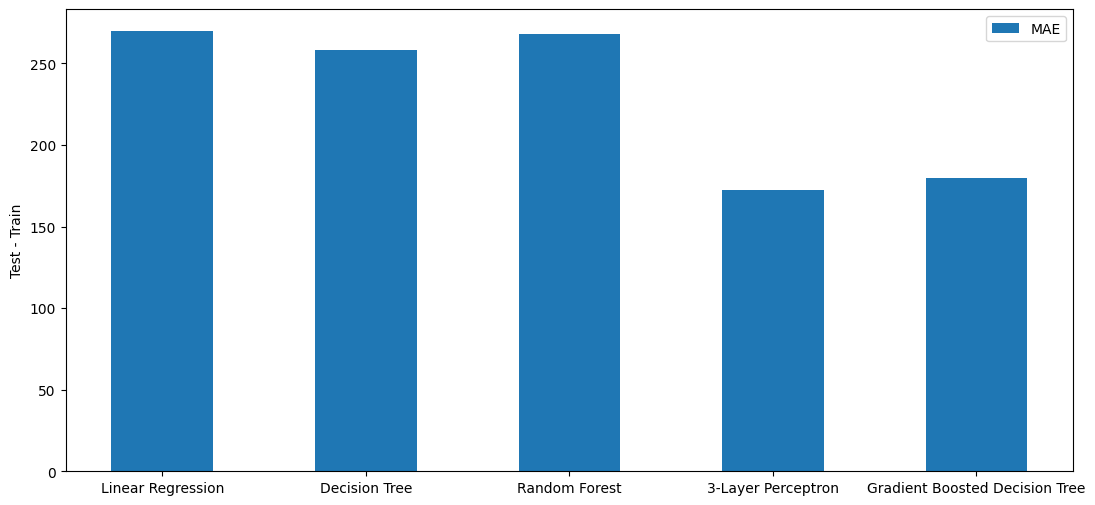

In [ ]:
plt.figure(figsize=(13,6))
plt.bar(X_axis, m2[:, 0], 0.5, label = 'MAE')
plt.xticks(X_axis, [name2better[x.split("_")[0]] for x in X])
plt.ylabel("Test - Train")
plt.legend()
plt.show()

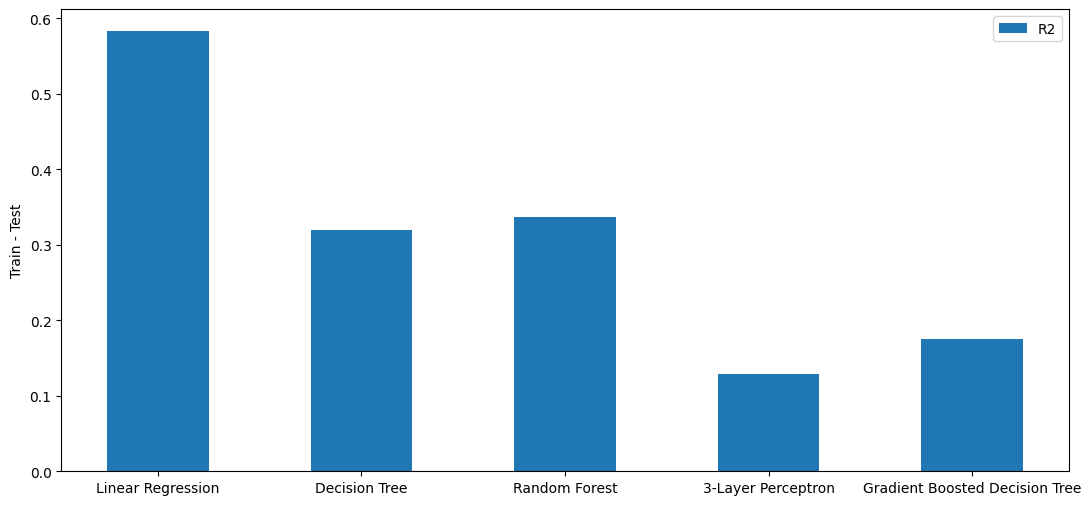

In [ ]:
plt.figure(figsize=(13,6))
plt.bar(X_axis, m3[:, 0], 0.5, label = 'R2')
plt.xticks(X_axis, [name2better[x.split("_")[0]] for x in X])
plt.ylabel("Train - Test")
plt.legend()
plt.show()